In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings   
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# pretty display of variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Define Neural network
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
net.load_state_dict(torch.load('../models/untuned-mvp.pt'))
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)

In [5]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())


Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([11, 84])
fc3.bias 	 torch.Size([11])


In [6]:
net.state_dict()['conv1.bias']

tensor([ 0.1158,  0.0227,  0.1451,  0.0033, -0.0611,  0.0731])

## Prep tweet image data

In [7]:
# Loading in data

class Food11Dataset(Dataset):
    """Food 11 dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.index_file = pd.read_csv(csv_file) # first column: image_name (i.e. 0809-personal.jpg)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.index_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.index_file.iloc[idx, 0]) # get filepath to image
        image = io.imread(img_name)
        label = self.index_file.iloc[idx, 1] # get the labels

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Transforms
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w, 3)) ## ensure 3 channels

        return img


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return torch.from_numpy(image)

In [9]:
# Ready to load + transform images
my_transform = transforms.Compose([
                                   Rescale(64),
                                   RandomCrop(32),
                                   ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])

In [9]:
# def write_names(dir_name, csv_fn):
#     '''Write file names in folder to csv.'''
#     img_names  = os.listdir(dir_name)
#     with open(csv_fn, 'w+') as f:
#         f.write('img_name,label\n')
#         for i in range(len(img_names)):
#             img_name = img_names[i]
#             img_label = '-1'
#             row = f'{img_name},{img_label}\n'
#             f.write(row)
# write_names('../output/imgs/', '../output/tweet-imgs-index.csv')

In [11]:
tweetset = Food11Dataset(csv_file='../output/tweet-imgs-index2.csv',
                         root_dir='../output/imgs/',
                        transform=my_transform)


In [22]:
tweetloader = DataLoader(tweetset, batch_size=4,
                         shuffle=False, num_workers=0) #num_workers=0 because can't parallelize in Windows
classes = ('bread', 'dairy-product', 'dessert', 'egg', 'fried-food', 'meat', 'noodles/pasta', 'rice', 'seafood', 'soup', 'vegetable', 'fruit') # tuple that I can index into

In [13]:
len(tweetset)

1479

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) ## move around the dimensions: # 3*32*32 --> 32*32*3

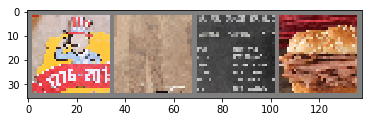

In [37]:
sample = iter(tweetloader)
imgs, lbls = sample.next()
imshow(utils.make_grid(imgs))
# print('GroundTruth: ', ' '.join('%5s' % classes[lbls[j]] for j in range(4)))

In [38]:
predict = net(imgs.float())
_, y = torch.max(predict, 1)
y
print('My guess: ', ' '.join('%5s' % classes[y[j]] for j in range(4)))

tensor([5, 9, 8, 2])

My guess:   meat  soup seafood dessert


In [23]:
# get all predicted values
Yhat = torch.tensor([], dtype=torch.long)
with torch.no_grad():
    for i_batch, data in enumerate(tweetloader):
        images, labels = data
        outputs = net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        Yhat = torch.cat((Yhat, predicted))
        
        if i_batch % 25 == 0:
            print(Yhat.size())

torch.Size([4])
torch.Size([104])
torch.Size([204])
torch.Size([304])
torch.Size([404])
torch.Size([504])
torch.Size([604])
torch.Size([704])
torch.Size([804])
torch.Size([904])
torch.Size([1004])
torch.Size([1104])
torch.Size([1204])
torch.Size([1304])
torch.Size([1404])


In [24]:
len(Yhat)

1479

In [21]:
print(' '.join(classes[Yhat[j]] for j in range(len(Yhat[:100])))) 

dessert dessert dessert meat egg dessert dessert dessert seafood soup dessert dessert meat egg dessert dessert dessert dessert egg dessert dessert meat dessert dessert dessert dessert egg egg dessert dessert dessert egg meat soup meat dessert dessert soup soup dessert dessert meat meat meat meat dessert soup dessert soup meat dessert dessert seafood soup dessert soup dessert meat dessert soup dessert dessert soup soup soup seafood dessert meat dessert soup dessert soup dessert dessert dessert dessert soup soup bread dessert egg soup soup dessert dessert dessert soup soup soup soup soup egg soup dessert fried-food dessert meat dessert meat meat


In [29]:
print(' '.join(classes[Yhat[j]] for j in range(len(Yhat[:100])))) 

dessert soup dessert dessert egg soup dessert fried-food meat dessert dessert dessert soup egg soup dessert dessert dessert egg dessert dessert dessert dessert soup dessert dessert egg egg dessert dessert dessert egg meat egg dessert seafood dessert meat soup meat dessert meat dessert dessert meat soup dessert soup soup dessert dessert dessert soup soup dessert dessert dessert meat meat dessert dessert dessert soup soup soup dessert dessert meat dessert dessert dessert dessert dessert dessert egg dessert soup dessert dessert dessert egg soup soup dessert dessert dessert soup soup soup dessert soup dessert soup dessert dessert seafood dessert dessert meat meat


In [131]:
Yhat.size()

torch.Size([1480])

In [159]:
Yhat.size()

torch.Size([1480])

In [160]:
def write_predicted(dir_name, csv_fn):
    '''Write file names in folder to csv.'''
    img_names  = os.listdir(dir_name)
    with open(csv_fn, 'w+') as f:
        f.write('img_name,label\n')
        for i in range(len(img_names)):
            img_name = img_names[i]
            img_label = Yhat[i]
            row = f'{img_name},{img_label}\n'
            f.write(row)
write_predicted('../output/imgs/', '../output/actual-nnet-out.csv')

In [42]:
input_index = pd.read_csv('../output/tweet-imgs-index2.csv')
YhatLabels = [classes[y] for y in Yhat]
YhatLabels[:5]

['dessert', 'soup', 'dessert', 'dessert', 'egg']

In [43]:
input_index['label'] = YhatLabels
file_loc = '../output/actual-nnet-output.csv'
input_index.to_csv(file_loc, index=False, mode='w+')

## Advertising for fake client

In [44]:
def write_names(dir_name, csv_fn):
    '''Write file names in folder to csv.'''
    img_names  = os.listdir(dir_name)
    with open(csv_fn, 'w+') as f:
        f.write('img_name,label\n')
        for i in range(len(img_names)):
            img_name = img_names[i]
            img_label = '-1'
            row = f'{img_name},{img_label}\n'
            f.write(row)
write_names('../data/Fake-Client/imgs', '../data/Fake-Client/fclient-imgs-index.csv')

In [46]:
jolliset = Food11Dataset(csv_file='../data/Fake-Client/fclient-imgs-index.csv',
                         root_dir='../data/Fake-Client/imgs',
                        transform=my_transform)


In [59]:
jolliloader = DataLoader(jolliset, batch_size=4,
                         shuffle=False, num_workers=0) #num_workers=0 because can't parallelize in Windows
classes = ('bread', 'dairy-product', 'dessert', 'egg', 'fried-food', 'meat', 'noodles/pasta', 'rice', 'seafood', 'soup', 'vegetable', 'fruit') # tuple that I can index into

In [88]:
dataiter = iter(jolliloader)

tensor([2, 9, 5, 9])
My guess:  dessert  soup  meat  soup


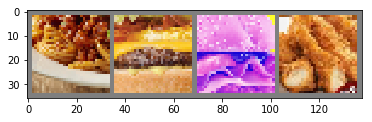

In [89]:
imgs1, _ = dataiter.next()
predict = net(imgs1.float())
_, y1 = torch.max(predict, 1)
print(y1)
print('My guess: ', ' '.join('%5s' % classes[y1[j]] for j in range(4)))
imshow(utils.make_grid(imgs1))

tensor([2, 5, 2, 2])
My guess:  dessert  meat dessert dessert


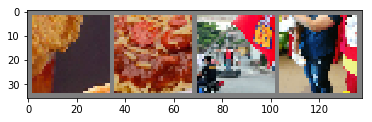

In [90]:
imgs2, _ = dataiter.next()
predict = net(imgs2.float())
_, y2 = torch.max(predict, 1)
print(y2)
print('My guess: ', ' '.join('%5s' % classes[y2[j]] for j in range(4)))
imshow(utils.make_grid(imgs2))

In [91]:
yhat = torch.cat((y1, y2))

yhat_labels = [classes[y] for y in yhat]
yhat_labels

['dessert', 'soup', 'meat', 'soup', 'dessert', 'meat', 'dessert', 'dessert']

In [94]:
input_index = pd.read_csv('../data/Fake-Client/fclient-imgs-index.csv')

input_index['label'] = yhat_labels
# file_loc = '../output/actual-nnet-output.csv'
# input_index.to_csv(file_loc, index=False, mode='w+')
input_index

,img_name,label
0,878264dc-f7ea-453f-9ae5-66c95cdbc888.jpg,dessert
1,alohayumburgerinside.jpg,soup
2,Hawaiian-chicken-Burger-Website-Image.png,meat
3,images.jpg,soup
4,jollibee-chickenjoy.jpg,dessert
5,Jollibee-Spaghetti640.jpg,meat
6,jollibee_5.png,dessert
7,Ykaie-Jollibee-Party22.png,dessert


## Generating tweet from our database

In [95]:
tweet_db = pd.read_csv('../output/actual-nnet-output.csv')
tweet_db.head()

,img_name,label,tweet,link
0,Arbys-i1062782215786979328.jpg,dessert,We're feelin' the spirit of '76 https://t.co/Y...,http://pbs.twimg.com/media/Dr-NIFBXQAEHpXW.jpg
1,Arbys-i1060562590357700609.jpg,soup,Why maintaining proper intervals is so importa...,http://pbs.twimg.com/tweet_video_thumb/DrfbyZd...
2,Arbys-i1059475431227879428.jpg,dessert,Having trouble growing out that 'stache? Use o...,http://pbs.twimg.com/media/DrPtCjbXcAETtYg.jpg
3,Arbys-i1058735553326137344.jpg,dessert,Which sandwich should YOU buy to celebrate #Na...,http://pbs.twimg.com/tweet_video_thumb/DrFUZqd...
4,Arbys-i1058044649053585408.jpg,egg,@JalenandJacoby Far be it from us to deny the ...,http://pbs.twimg.com/media/Dq7t_2cX0AEe1nX.jpg


In [96]:
def get_tweet_db(df, my_label):
    df = df[df.label == my_label]
    return df.tweet.tolist()

In [98]:
a = get_tweet_db(tweet_db, 'dessert')
len(a)

751

In [99]:
tweet_dict = {}
total_tweets = 0
for l in classes:
    my_tweets = get_tweet_db(tweet_db, l)
    print(l, len(my_tweets))
    tweet_dict[l] = my_tweets
    total_tweets += len(my_tweets)

bread 25
dairy-product 12
dessert 751
egg 212
fried-food 17
meat 171
noodles/pasta 0
rice 0
seafood 77
soup 214
vegetable 0
fruit 0


In [100]:
total_tweets ## correct is 1479

1479

In [102]:
import random
def generate_tweet(tweet_dict, my_class):
    twts = tweet_dict[my_class]
    return twts[random.randint(0, len(twts) - 1)]

In [110]:
input_index

,img_name,label,tweet
0,878264dc-f7ea-453f-9ae5-66c95cdbc888.jpg,dessert,Talk about an ideal fantasy. #GameOfThrones ht...
1,alohayumburgerinside.jpg,soup,BWAAAH! https://t.co/xnmC9412xY
2,Hawaiian-chicken-Burger-Website-Image.png,meat,Eat your greens this holiday season with the n...
3,images.jpg,soup,The Slams have twins. Who knew? https://t.co/x...
4,jollibee-chickenjoy.jpg,dessert,Jam with the Slams and get that singing food h...
5,Jollibee-Spaghetti640.jpg,meat,D.J. Tanner consoling this bronco on Full Hous...
6,jollibee_5.png,dessert,Welcome to the Veggie and Black Bean Slider sp...
7,Ykaie-Jollibee-Party22.png,dessert,big night tonight. #ItsCrunchTime https://t.co...


In [107]:
input_index['tweet'] = input_index['label'].apply(lambda x: generate_tweet(tweet_dict, x))

In [109]:
file_loc = '../data/Fake-Client/generated-tweets.csv'
input_index.to_csv(file_loc, index=False, mode='w+')
